# CWRU Bearing Fault Diagnosis with Spectrogram and Scalogram Inputs

This notebook implements a Convolutional Neural Network (CNN) for fault diagnosis of rolling element bearings using the Case Western Reserve University (CWRU) dataset. The methodology is based on Verstraete et al. (2017), which uses time-frequency image representations (spectrograms via STFT and scalograms via Morlet wavelet transform) as inputs to a CNN. The CNN architecture features double convolutional layers before pooling to enhance feature expressivity.


## Overview
- **Dataset**: CWRU Bearing Data (2HP load, various fault types and sizes)
- **Input**: 96x96 pixel spectrogram or scalogram images
- **Model**: CNN with three stages of double conv layers (32, 64, 128 filters), max pooling, and two dense layers
- **Training**: 5-fold stratified cross-validation with early stopping
- **Evaluation**: Accuracy, confusion matrices, and fold-wise performance plots

## Requirements
- Python libraries: tensorflow, numpy, scipy, scikit-learn, matplotlib, seaborn, pywt, skimage
- CWRU dataset files in 'CWRU_BearingData_Load_2HP' folder

Run cells sequentially to load data, preprocess, train the model, and evaluate results.

In [1]:
# Setup for Reproducibility
import tensorflow as tf
import numpy as np
import random
import os

# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Import additional libraries
import scipy.io
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from skimage.transform import resize
import pywt  # For wavelet transform

## Load CWRU Bearing Data

The `ImportData` function loads the CWRU dataset files (.mat) containing vibration signals for normal and fault conditions (inner race, ball, outer race) at various fault sizes under a 2HP load. The data is stored in a list for further processing.

In [2]:
def ImportData():
    folder_path = 'CWRU_BearingData_Load_2HP'
    file_paths = [
        os.path.join(folder_path, '99.mat'),
        os.path.join(folder_path, '111.mat'),
        os.path.join(folder_path, '124.mat'),
        os.path.join(folder_path, '137.mat'),
        os.path.join(folder_path, '176.mat'),
        os.path.join(folder_path, '191.mat'),
        os.path.join(folder_path, '203.mat'),
        os.path.join(folder_path, '215.mat'),
        os.path.join(folder_path, '228.mat'),
        os.path.join(folder_path, '240.mat')
    ]
    data_keys = [
        'X099_DE_time', 'X111_DE_time', 'X124_DE_time', 'X137_DE_time',
        'X176_DE_time', 'X191_DE_time', 'X203_DE_time', 'X215_DE_time',
        'X228_DE_time', 'X240_DE_time'
    ]
    data = [scipy.io.loadmat(fp)[key] for fp, key in zip(file_paths, data_keys)]
    return data

## Time-Frequency Image Generation

The following functions generate spectrogram and scalogram images from vibration signal segments, as per Verstraete et al. (2017):
- **Spectrogram**: Uses Short-Time Fourier Transform (STFT) with a Hann window, 256-point segments, and 128-point overlap. Images are normalized and resized to 96x96 pixels.
- **Scalogram**: Uses Continuous Wavelet Transform (CWT) with the Morlet wavelet, scales 1 to 128. Magnitude is normalized and resized to 96x96 pixels.

In [3]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape=(96, 96)):
    """
    Calculate the spectrogram of an array data_y_vector and resize it to image_shape.
    """
    fs = 48000
    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs,
        nperseg=256,
        noverlap=128,
        window='hann'
    )
    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)
    return sxx

def generate_scalogram_image(data_y_vector, image_shape=(96, 96)):
    """
    Calculate the scalogram using Morlet wavelet and resize it to image_shape.
    """
    fs = 48000
    scales = np.arange(1, 128)  # Adjust scales for Morlet wavelet
    coef, freqs = pywt.cwt(
        data_y_vector,
        scales,
        'morl',
        sampling_period=1/fs
    )
    coef = np.abs(coef)  # Use magnitude
    coef = min_max_norm(coef)
    coef = resize(coef, image_shape, mode='constant', anti_aliasing=True)
    return coef

## Data Preprocessing

The `Sampling` function segments the vibration signals into blocks, and `DataPreparation` generates spectrogram or scalogram images for each segment. Labels are created in one-hot encoded format (`Y_CNN`) for CNN training and as integers (`Y`) for stratification. The output is a 4D array of images and corresponding labels.

In [4]:
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T
    return SplitData

def DataPreparation(Data, interval_length, samples_per_block, image_type='spectrogram'):
    """
    Prepare data by generating spectrogram or scalogram images.
    """
    X = []
    LabelPositional = []
    Label = []
    for count, data in enumerate(Data):
        SplitData = Sampling(data, interval_length, samples_per_block)
        images = []
        for segment in SplitData:
            if image_type == 'spectrogram':
                img = generate_spectrogram_image(segment)
            elif image_type == 'scalogram':
                img = generate_scalogram_image(segment)
            images.append(img)
        images = np.array(images)
        y = np.zeros([len(SplitData), 10])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        X.append(images)
        LabelPositional.append(y)
        Label.append(y1)
    X = np.concatenate(X, axis=0)
    LabelPositional = np.concatenate(LabelPositional, axis=0)
    Label = np.concatenate(Label, axis=0)
    return X, LabelPositional, Label

## CNN Model Definition

The `CNN_2D` class defines the CNN architecture as per Verstraete et al. (2017):
- Three stages, each with two convolutional layers (32, 64, 128 filters, 3x3 kernels) followed by 2x2 max pooling.
- Two dense layers (100 units each) with dropout (0.5) before the second dense layer.
- Output layer with 10 units (softmax) for 10-class classification.
- Compiled with Adam optimizer and categorical crossentropy loss.

In [5]:
class CNN_2D():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 1)),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(96, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

## Main Execution

This section executes the pipeline:
- Loads and preprocesses data to generate 96x96 images (spectrogram or scalogram).
- Splits data into training (80%) and test (20%) sets with stratification.
- Performs 5-fold cross-validation with early stopping and model checkpointing.
- Saves the best model for each fold.

**Parameters**:
- `image_type`: Set to 'scalogram' or 'spectrogram' to choose input type.
- `image_shape`: 96x96 pixels for high accuracy (per Verstraete et al.).
- `kSplits`: 5 for cross-validation.
- `foldername`: Directory to save model checkpoints.

In [8]:
# Parameters
interval_length = 1600
samples_per_block = 1600
image_type = 'scalogram'  # Change to 'spectrogram' to use spectrograms
image_shape = (96, 96)
kSplits = 5
foldername = "CNN2D_results/ScalogramHP2-96x96/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

# Load and prepare data
Data = ImportData()
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block, image_type=image_type)
Input_2D = X.reshape([-1, image_shape[0], image_shape[1], 1])
print(f"Shape of Input Data: {Input_2D.shape}")

# Train-test split
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(
    Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y
)


Shape of Input Data: (3026, 96, 96, 1)


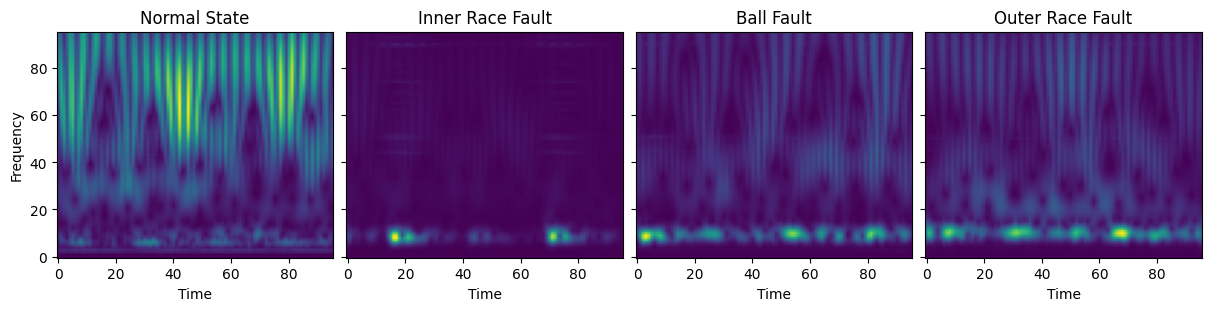

In [ ]:
# Create a figure with four subplots, sharing the y-axis
fig, (plt1, plt2, plt3, plt4) = plt.subplots(1, 4, sharey=True, figsize=(12, 3), constrained_layout=True)

# Plot Normal state spectrogram (index 0, assuming Normal samples are at the start)
plt1.set_xlabel("Time")
plt1.set_ylabel("Scale")
plt1.set_title('Normal State')
plt1.imshow(Input_2D[0, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Inner Race fault spectrogram (index 1000, assuming Inner Race samples around this index)
plt2.set_xlabel("Time")
plt2.set_title('Inner Race Fault')
plt2.imshow(Input_2D[1000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Ball fault spectrogram (index 2000, assuming Ball fault samples around this index)
plt3.set_xlabel("Time")
plt3.set_title('Ball Fault')
plt3.imshow(Input_2D[2000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Outer Race fault spectrogram (index 2500, assuming Outer Race samples around this index)
plt4.set_xlabel("Time")
plt4.set_title('Outer Race Fault')
plt4.imshow(Input_2D[2500, :, :], aspect='auto', origin='lower', cmap='viridis')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# K-fold cross-validation
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True)
accuracy_train = []
accuracy_val = []
accuracy_test = []
precision_val = []
recall_val = []
f1_val = []
pred_all_val = np.zeros([len(X_2D_train), 10])
y_2D_val = np.zeros([len(X_2D_train), 10])
kfold_test_len = []
fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Train the model
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):
    checkpoint_filepath = foldername + f"best_model_{k}.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    Classification_2D = CNN_2D()
    history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )
    print(f"Best model saved at: {checkpoint_filepath}")
    CNN_2D_best_model = load_model(checkpoint_filepath)
    print("Best model loaded successfully!")
    
    fl2 = fl1 + len(test)
    pred_all_val[fl1:fl2, :] = CNN_2D_best_model.predict(X_2D_train[test])
    y_2D_val[fl1:fl2, :] = y_2D_train[test]
    kfold_test_len.append(fl2 - fl1)
    fl1 = fl2

    train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train])
    accuracy_train.append(train_accuracy)
    val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test])
    accuracy_val.append(val_accuracy)
    test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test)
    accuracy_test.append(test_accuracy)


    # Calculate precision, recall, and F1 score for validation set
    y_pred_val = np.argmax(CNN_2D_best_model.predict(X_2D_train[test]), axis=1)
    y_true_val = np.argmax(y_2D_train[test], axis=1)
    precision_val.append(precision_score(y_true_val, y_pred_val, average='weighted'))
    recall_val.append(recall_score(y_true_val, y_pred_val, average='weighted'))
    f1_val.append(f1_score(y_true_val, y_pred_val, average='weighted'))
    
    k += 1

KeyboardInterrupt: 

## Model Evaluation

Evaluate the trained model by computing average accuracies across folds for training, validation, and test sets. Visualize performance with confusion matrices for train and test sets, and bar plots for fold-wise and train vs. test accuracies.

CNN 2D train accuracy = 100.0
CNN 2D validation accuracy = 99.8763918876648
CNN 2D test accuracy = 99.86816048622131


2025-06-12 19:33:40.458149: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 19:33:40.461007: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 2048, but received input with shape (32, 18432)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 96, 96, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

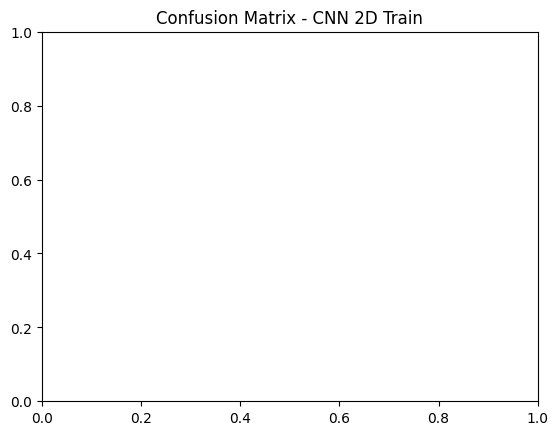

In [ ]:
CNN_2D_train_accuracy = np.average(accuracy_train) * 100
print(f'CNN 2D train accuracy = {CNN_2D_train_accuracy}')
CNN_2D_val_accuracy = np.average(accuracy_val) * 100
print(f'CNN 2D validation accuracy = {CNN_2D_val_accuracy}')
CNN_2D_test_accuracy = np.average(accuracy_test) * 100
print(f'CNN 2D test accuracy = {CNN_2D_test_accuracy}')

def ConfusionMatrix(Model, X, y):
    y_pred = np.argmax(Model.predict(X), axis=1)
    ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
    return ConfusionMat

# Plot results
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70, 100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])
plt.show()

In [ ]:
CNN_2D_val_precision = np.average(precision_val) * 100
CNN_2D_val_recall = np.average(recall_val) * 100
CNN_2D_val_f1 = np.average(f1_val) * 100

# Calculate metrics for test set
y_pred_test = np.argmax(CNN_2D_best_model.predict(X_2D_test), axis=1)
y_true_test = np.argmax(y_2D_test, axis=1)
CNN_2D_test_precision = precision_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_recall = recall_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_f1 = f1_score(y_true_test, y_pred_test, average='weighted') * 100

print('CNN 2D Validation Precision = {:.2f}%'.format(CNN_2D_val_precision))
print('CNN 2D Validation Recall = {:.2f}%'.format(CNN_2D_val_recall))
print('CNN 2D Validation F1 Score = {:.2f}%'.format(CNN_2D_val_f1))
print('CNN 2D Test Precision = {:.2f}%'.format(CNN_2D_test_precision))
print('CNN 2D Test Recall = {:.2f}%'.format(CNN_2D_test_recall))
print('CNN 2D Test F1 Score = {:.2f}%'.format(CNN_2D_test_f1))

# Plot train vs test metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Train vs Test Metrics')

ax1.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Train', 'Test'])
ax1.set_ylim([70, 100])

ax2.bar([1, 2], [CNN_2D_val_precision, CNN_2D_test_precision])
ax2.set_title('Precision')
ax2.set_ylabel('Precision (%)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Train', 'Test'])
ax2.set_ylim([70, 100])

ax3.bar([1, 2], [CNN_2D_val_recall, CNN_2D_test_recall])
ax3.set_title('Recall')
ax3.set_ylabel('Recall (%)')
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Train', 'Test'])
ax3.set_ylim([70, 100])

ax4.bar([1, 2], [CNN_2D_val_f1, CNN_2D_test_f1])
ax4.set_title('F1 Score')
ax4.set_ylabel('F1 Score (%)')
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Train', 'Test'])
ax4.set_ylim([70, 100])

plt.tight_layout()
plt.show()

## Notes

- **Running the Notebook**: Ensure the CWRU dataset files are in the 'CWRU_BearingData_Load_2HP' folder. Install required libraries (e.g., `pip install PyWavelets` for pywt).
- **Switching Input Types**: Change `image_type` to 'spectrogram' in the main execution cell to use spectrograms instead of scalograms.
- **Performance**: Per Verstraete et al., scalograms achieve up to 99.5% accuracy on CWRU data with 96x96 images, outperforming spectrograms (99.5%) and HHT (97.6%).
- **Scalability**: 96x96 images increase computational load. For lower memory usage, set `image_shape = (32, 32)`, but expect reduced accuracy (e.g., 98.8% for scalograms).

This notebook provides an interactive environment to experiment with time-frequency-based fault diagnosis, leveraging the strengths of CNNs for automatic feature learning.